In [1]:
import sys
import wave
import pickle
import numpy as np
import matplotlib.pyplot as plt
import librosa
import torch
import librosa.display
import tensorflow as tf
from pytorch_pretrained_biggan import (BigGAN, one_hot_from_names, truncated_noise_sample,
                                       save_as_images, display_in_terminal)
from PIL import Image

In [2]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/jonas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
form = 8
channels = 2
rate = 44100
CHUNK = 2**11
hop_length = CHUNK//2

In [4]:
#input shape = [?,100]
#generator = tf.keras.models.load_model("../../Networks/generator.hdf5")

model_name='biggan-deep-' + "128"
model = BigGAN.from_pretrained(model_name)

In [19]:
# Prepare a input
truncation = 1
class_vector = one_hot_from_names(['house'], batch_size=1)
noise_vector = truncated_noise_sample(truncation=truncation, batch_size=1)

# All in tensors
noise_vector = torch.from_numpy(noise_vector)
class_vector = torch.from_numpy(class_vector)

print(noise_vector.shape)
print(class_vector.shape)

with torch.no_grad():
    output = (model(noise_vector, class_vector, truncation).numpy() +1)/2 * 255
    print(np.min(output[0]))
    #img = np.rollaxis(output[0], 0, 3).astype(np.uint8)
    img = output[0].astype(np.uint8)
    print(img.shape)
    pil_img = Image.fromarray(img)
plt.imshow(pil_img)

torch.Size([1, 128])
torch.Size([1, 1000])
0.846397
(3, 128, 128)


TypeError: Cannot handle this data type: (1, 1, 128), |u1

In [7]:
lib_song, sr = librosa.load("../Music/beethovenwav.wav")

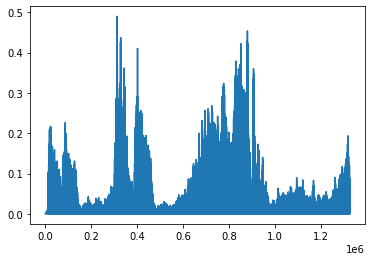

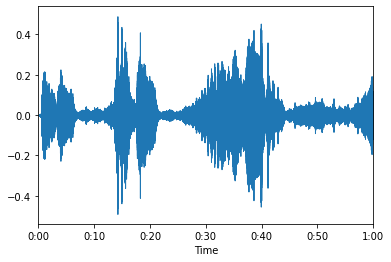

In [8]:
plt.plot(abs(lib_song))
plt.show()
librosa.display.waveplot(lib_song, sr=sr)

In [ ]:
grads = []
num_inbetweens = 20
n_mels = 128
mel = librosa.filters.mel(sr=sr, n_fft=CHUNK, n_mels=n_mels)
frames = []
num_classes = 12



for i in range(len(lib_song)//CHUNK):
    if i%10 == 0:
        inp_vec = np.random.normal(size = 100)
        print(i, len(lib_song)//CHUNK)
    for sample in [lib_song[CHUNK*i:CHUNK*(i+1)]]:
        ft_sample = librosa.stft(sample, n_fft=CHUNK, hop_length=CHUNK+1)
        
        amp = np.abs(ft_sample)**2
        spec = mel.dot(amp)
        
        grad = get_gradient(np.squeeze(spec))
        chroma = get_pitches(spec)

        cv1=np.zeros(1000)
        chromasort=np.argsort(np.mean(chroma,axis=1))[::-1]
        for pi,p in enumerate(chromasort[:num_classes]):
            cv1[pi] = p
            
        class_vectors= torch.Tensor(np.array([cv1])) 
        
        #print(noise_vector.shape)
        #print(class_vectors.shape)
        frames.append(model(noise_vector*grad, class_vectors, 1))


0 646


/home/jonas/.local/lib/python3.8/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


In [10]:
def get_gradient(seq, clip=True): #Have to figure out how to normalize if necessary
    grad = np.gradient(seq)     
    if clip:
        grad = grad.clip(min=0)
    return grad

In [11]:
def get_pitches(spec):
    chroma = librosa.feature.chroma_stft(S=spec,sr=sr)
    return chroma

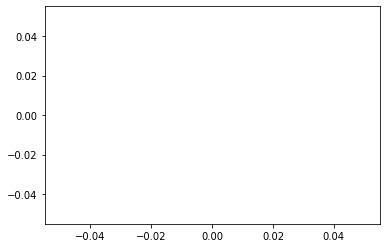

In [12]:
plt.plot(grads)
plt.show()

In [13]:
print(np.asarray(grads).shape)

(0,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


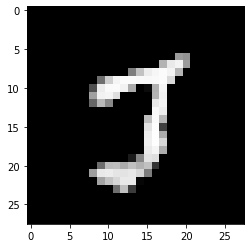

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


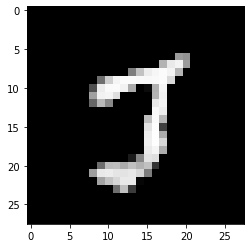

In [28]:
for image in frames[:2]:
    plt.imshow(image)
    plt.show()
    

In [29]:
vid = np.asarray(frames)

In [30]:
print(len(frames)/len(lib_song))
print(44100*(len(frames)/len(lib_song)))

0.0004880363111103053
21.522401319964462


In [31]:
import moviepy.editor as mpy


In [32]:
aud = mpy.AudioFileClip("clip.wav", fps = 44100)

In [33]:
print(aud.duration)

60.03


In [34]:
print(len(lib_song))
import scipy

1323672


In [35]:
scipy.io.wavfile.write(data = lib_song, rate = sr, filename="clip.wav")

In [36]:
clip = mpy.ImageSequenceClip(frames, fps=22050*(len(frames)/len(lib_song)))
clip = clip.set_audio(aud)
clip.write_videofile("vid_clip.mp4",audio_codec='aac')

chunk:   7%|▋         | 99/1324 [00:00<00:01, 989.95it/s, now=None]

Moviepy - Building video vid_clip.mp4.
MoviePy - Writing audio in vid_clipTEMP_MPY_wvf_snd.mp4


MoviePy - Done.
Moviepy - Writing video vid_clip.mp4

Moviepy - Done !
Moviepy - video ready vid_clip.mp4


In [42]:
clip = mpy.ImageSequenceClip(fake_clip, fps=1)

In [41]:
fake_clip = [np.ones([28,28,3])]*100

In [44]:
frames_3 = list(map(lambda img: np.stack((img,)*3, axis=-1), frames))